# Customer Segmentation for UK Online Retail

- The Online Retail dataset is a dataset which contains all transactions for UK Online Retailer between January 2010 and December 2011. The goal of this project is to segment different groups of customers using K-Means clustering and Hierarchical clustering. The dataset can be found here: https://archive.ics.uci.edu/dataset/352/online+retail. 

In [1]:
import pandas as pd

In [2]:
retail_data = pd.read_excel("retail_data.xlsx")

In [3]:
retail_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
retail_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

- It will be impossible to perform any imputation of missing values for the Customer ID and Description variables. Therefore, the null rows will be dropped. 

In [5]:
retail_data.shape

(541909, 8)

In [6]:
retail_data = retail_data.dropna()

- Next, the variables used to segment the different customers will need to be chosen.
- A 'Total Amount' variable will also be useful to determine how much was paid in each transaction:

In [7]:
retail_data['TotalAmount'] = retail_data['Quantity'] * retail_data['UnitPrice']

- The number of different purchases made by each customer, as well knowing when the most recent purchase made by each customer was will also be useful in determining how to segment each customer:

In [8]:
most_recent= max(retail_data["InvoiceDate"]) + pd.DateOffset(days=1)
retail_data["PurchaseTime"] = most_recent - retail_data["InvoiceDate"]
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,PurchaseTime
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,374 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,374 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,374 days 04:24:00


In [9]:
grouped_data = retail_data.groupby('CustomerID').agg(
    MostRecentPurchase=('PurchaseTime', 'min'), 
    CustomerTotal=('TotalAmount', 'sum'),   
    CustomerFrequency=('CustomerID', 'size')).reset_index()

In [10]:
grouped_data.head()

,CustomerID,MostRecentPurchase,CustomerTotal,CustomerFrequency
0,12346.0,326 days 02:33:00,0.00,2
1,12347.0,2 days 20:58:00,4310.00,182
2,12348.0,75 days 23:37:00,1797.24,31
3,12349.0,19 days 02:59:00,1757.55,73
4,12350.0,310 days 20:49:00,334.40,17


- The data will also need to be scaled and the ID column will need to be removed before clustering the customers:

In [11]:
final_data = grouped_data.drop(columns=["CustomerID"])
final_data["MostRecentPurchase"] = final_data["MostRecentPurchase"].dt.days # use just the number of days

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
scaler = StandardScaler()

In [14]:
scaled_data = scaler.fit_transform(final_data)
scaled_data = pd.DataFrame(scaled_data, columns=final_data.columns)

In [15]:
scaled_data.head()

,MostRecentPurchase,CustomerTotal,CustomerFrequency
0,2.322023,-0.231001,-0.391720
1,-0.893733,0.293432,0.382657
2,-0.169196,-0.012316,-0.266959
3,-0.725005,-0.017146,-0.086271
4,2.163220,-0.190312,-0.327188


### Creating Clusters

- First, a K-Means appraoch will be used:

In [16]:
from sklearn.cluster import KMeans

In [17]:
from sklearn.metrics import silhouette_score        

In [18]:
s_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, n_init=10).fit(scaled_data) # experimenting wth different k values
    s_scores.append([k, silhouette_score(scaled_data, kmeans.labels_)])


In [19]:
import matplotlib.pyplot as plt

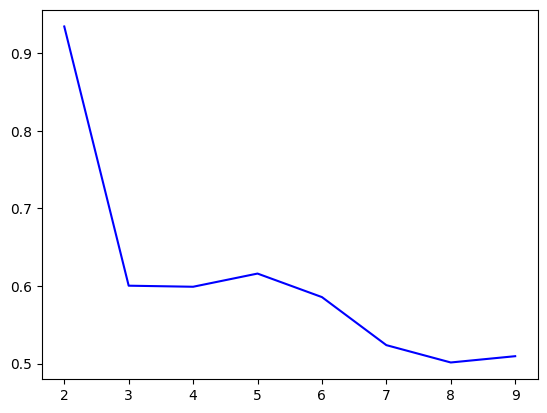

In [20]:
plt.plot(pd.DataFrame(s_scores)[0], pd.DataFrame(s_scores)[1],'b')

- The silhouette scores indicate splitting the data into two clusters produces the strongest separation between clusters. However, the silhouette scores are only an indication of the separation between clusters, but this does not mean using two clusters would produce the most meaningful clusters. The inertia of the different number of clusters may also be useful:

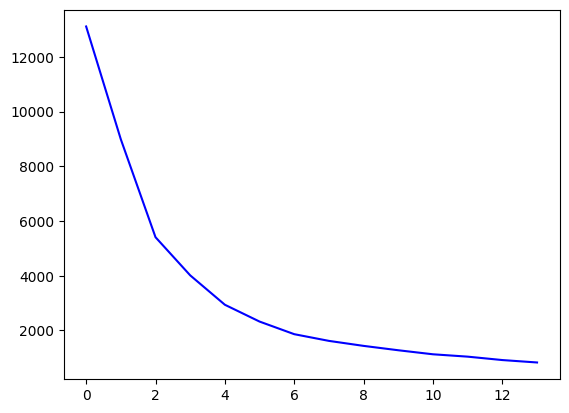

In [21]:
sq_dist_scores = []
for k in range(1,15):
    model_clus = KMeans(n_clusters = k, max_iter=50, n_init=10)
    model_clus.fit(scaled_data)
    sq_dist_scores.append(model_clus.inertia_)

plt.plot(sq_dist_scores,'b')

- After 5 clusters, the sum of squared distances begins levelling out.

In [22]:
kmeans = KMeans(n_clusters=5, max_iter=50, n_init=10)
kmeans.fit(scaled_data)

KMeans(max_iter=50, n_clusters=5, n_init=10)

In [23]:
# scaled_data.index = pd.RangeIndex(len(scaled_data.index))
data_kmeans = pd.concat([grouped_data, pd.Series(kmeans.labels_)], axis=1)
data_kmeans.columns = ['CustomerID', 'MostRecent', 'Amount', 'NumPurchases', 'ClusterID']

data_kmeans.MostRecent = data_kmeans.MostRecent.dt.days
grouped_kmeans = data_kmeans.groupby('ClusterID').agg(
    MeanAmount=('Amount', 'mean'),
    MeanMostRecent=('MostRecent', 'mean'),    
    MeanNumVisits=('NumPurchases', 'mean'))

In [24]:
grouped_kmeans.head()

,MeanAmount,MeanMostRecent,MeanNumVisits
ClusterID,,,
0,1288.344525,43.382392,73.976675
1,64776.602500,2.000000,5914.000000
2,466.779552,249.777570,27.699065
3,192103.854000,9.000000,1013.400000
4,10679.780241,12.285141,495.112450


- Cluster ID 3 spent significantly more on average than other clusters, but cluster ID 2's customers tended to visit the online retailer more frequently than other clusters.

- Hierarchical clustering can also be used:

In [25]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

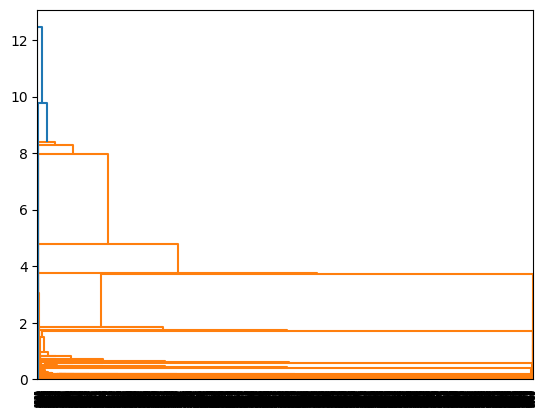

In [26]:
cluster_links = linkage(scaled_data, method = "single", metric='euclidean') # using a single link
dendrogram(cluster_links)
plt.show()

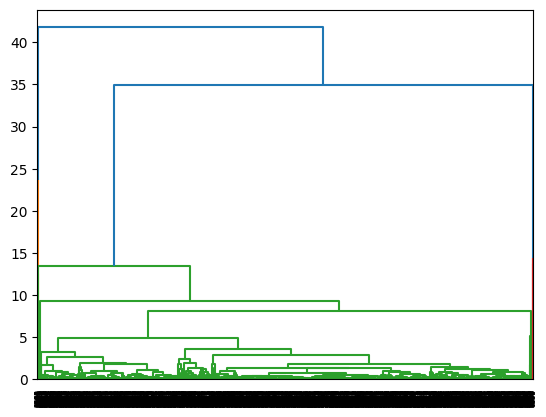

In [27]:
cluster_links = linkage(scaled_data, method = "complete", metric='euclidean') # linking clusters using a complete link
dendrogram(cluster_links)
plt.show()

- The dendograms show the difficulty in using a hierarchical clustering algorithm with large amounts of data. The relationships between the clusters at the lower levels become difficult to discern. However, they do show that clusters become more closely linked to one another as you move down the dendogram. This can help understand the optimal number of clusters to split the data ino. For example, with the dendogram made using a complete link between clusters, beyond the sixth cluster link (from top to bottom), the clusters become more and more similar, indicating there is less variability between the data points after using 6 clusters. 